In [ ]:
!pip install tensorboardX

In [ ]:
from __future__ import print_function, division

import csv
import json
from csv import reader
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import numpy as np
from numpy import printoptions
import torchvision
from tensorboardX import SummaryWriter
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import tqdm as tqdm
import ipywidgets as widgets
from PIL import Image
import shutil
from shutil import copyfile
from itertools import product
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import cv2
from torchvision.transforms import transforms as transforms
import math
import matplotlib
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

plt.ion()  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Image Pre Processing**
Originally, I ran the training using the plain images as provided. To improve on this, I ran the images through a PyTorch KeyPoint RCNN (reference: https://debuggercafe.com/human-pose-detection-using-pytorch-keypoint-rcnn/), which overlays an estimation of the skeletons in the image onto the image. 


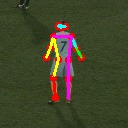

As it would often find multiple skeletons, I wrote some code to identify the most central skeleton in the image. To protect against the case when the only skeleton it could find wasn't in the middle of the image, I put a limit on how far the center of the skeleton could be from the middle of the image. 

This had a marked improvement on the performance of my model. 

I also boosted the size of my dataset by applying small transformations to each image to create 4 slightly different copies of each image.

In [ ]:
class ImageSetPreProcessor():
  def __init__(self, source_img_file, tgt_img_file, model):
    self.source_img_file = source_img_file
    self.tgt_img_file = tgt_img_file
    self.model = model
    self.action_dict = {'s': 'standing', 'w': 'walking', 'r': 'running' , 'si': 'sitting', 
                     'ot': 'one handed throw', 'tt': 'two handed throw', 'l': 'lunging',
                    'hd': 'hand dribbling', 'fd': 'foot dribbling', 'p': 'pointing', 'cr': 'crouching', 'bo': 'bowling', 'ba': 'batting', 'ca': 'catching', 
                     'k': 'kneeling', 'j': 'jumping', 'sl': 'sliding', 'o': 'on one leg'}
  
  def create_labels(self):
      labels = []
      csv_file = self.tgt_img_file + '.csv'
      total_labels = []
      label_dict = {}
      delete_dir = 'deleted_images'
      if not os.path.exists(delete_dir):
          os.mkdir(delete_dir)
      if not os.path.exists(self.tgt_img_file):
          os.mkdir(self.tgt_img_file)
      if not os.path.exists(csv_file):
          with open(csv_file,'w', newline='') as file:
              writer = csv.writer(file)
              writer.writerow(["Image", "Actions"])
          file.close()
      img_list = os.listdir(self.source_img_file)
      random.shuffle(img_list)
      img_list = [i for i in img_list]
      count = 0;
      for i in img_list:
          im = Image.open(os.path.join(self.source_img_file, i))
          print('Enter athletes action/s')
          inp = input()
          inp = inp.lower()
          plt.imshow(im)
          plt.show()
          if 'delete' in inp:
              shutil.move(os.path.join(self.source_img_file, i), delete_dir + '/')
              print('file ' + i + ' deleted and moved to deleted_images/' + i)
              continue
          elif 'break' in inp:
              break
          list = inp.split (" ")
          for label in list:
              if label in self.action_dict.keys():
                  labels.append(self.action_dict[label])
              else:
                  print('What is ' + label)
                  new_action = input()
                  new_action = new_action.lower()
                  labels.append(new_action)
          for l in labels:
              if l not in total_labels:
                  total_labels.append(l)
                  label_dict[l] = 1
              else:
                  label_dict[l] += 1
          with open(csv_file, 'a', newline='') as file:
              writer = csv.writer(file)
              writer.writerow([i, labels]) 
              shutil.move(os.path.join(self.source_img_file, i), self.tgt_img_file + '/')
          file.close()
          labels.clear()
          count += 1
          print('images labelled: ' + str(count))
      
      keys = label_dict.keys()
      values = label_dict.values()
      keys = np.array(keys)
      values = np.array(values)
      print(keys)
      print(values)


  #run augmentation on images before training to increase dataset volume
  def dataset_multiply(self, source_images ,csv_path):
      train_img = []
      new_imgs = os.path.join(path, source_images + '_multiply')
      new_csv = new_imgs + '.csv'
      if not os.path.exists(new_csv):
        with open(new_csv,'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Image", "Actions"])
        file.close()
      if not os.path.exists(new_imgs):
            os.mkdir(new_imgs)
      data = pd.read_csv(csv_path)
      for i in data['Image']:
          image_path = os.path.join(source_images, i)
          img = imread(image_path)
          img = img/255
          train_img.append(img)
      train_x = np.array(train_img)
      train_y = data['Actions'].values
      print(train_x.shape, train_y.shape)
      
      final_train_data = []
      final_target_train = []
      count = 0
      for i in range(0,train_x.shape[0]):
          final_train_data.append(train_x[i])
          final_train_data.append(rotate(train_x[i], angle=45, mode = 'wrap'))
          final_train_data.append(np.fliplr(train_x[i]))
          final_train_data.append(np.flipud(train_x[i]))
          final_train_data.append(random_noise(train_x[i],var=0.2**2))
          for j in range(5):
              final_target_train.append(train_y[i])
      print(len(final_target_train), len(final_train_data))
      final_train = np.array(final_train_data)
      final_target_train = np.array(final_target_train)
      for i in range(0, len(final_target_train)):
          img = final_train[i]
          img_name = str(i) + '.png'
          imsave(os.path.join(new_imgs,img_name), img)
          with open(new_csv, 'a') as f:
              writer = csv.writer(f)
              writer.writerow([img_name ,final_target_train[i]])
              print(img_name, final_target_train[i])
          f.close()

      
  def apply_skeleton(self, source_img_file):
    images = os.listdir(source_img_file)
    images = [i for i in images]
    for img in images:
      print(os.path.join(source_img_file, img))
      processed_img = ProcessedImage(self.model, os.path.join(source_img_file, img))
      processed_img.image.save(source_img_file + '/' + img)

In [ ]:
class ProcessedImage():
  def __init__(self, pose_detect_model, image_path):
    print(image_path)
    self.pose_detect_model = pose_detect_model
    self.image_path = image_path
    self.found_skeleton = False
    self.image = Image.open(image_path).convert('RGB')
    self.process_image(self.image_path)


  def __draw_keypoints(self, outputs, image):
    # the `outputs` is list which in-turn contains the dictionaries 
    limit = int(len(outputs[0]['keypoints']) - 1)
        # pairs of edges for 17 of the keypoints detected ...
    # ... these show which points to be connected to which point ...
    # ... we can omit any of the connecting points if we want, basically ...
    # ... we can easily connect less than or equal to 17 pairs of points ...
    # ... for keypoint RCNN, not  mandatory to join all 17 keypoint pairs
    edges = [
        (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
        (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
        (12, 14), (14, 16), (5, 6)
    ]
    outputs[0]['closest_to_center'] = {
        'point': 'n/a',
        'distance': 10000000
    }
    found_skeleton = False
    if limit == 0:
      return image, found_skeleton
    else:
      for i in range(0, limit):
        i = int(i)
        keypoints = outputs[0]['keypoints'][i].cpu().detach().numpy()
        if outputs[0]['scores'][i] > 0.95:
          keypoints = keypoints[:, :].reshape(-1, 3)
          count = 0
          highestX = -100000
          lowestX = 10000
          highestY = -100000
          lowestY = 10000
          for p in range(0,keypoints.shape[0] - 1):
            if int(keypoints[p, 0]) < lowestX:
              lowestX = int(keypoints[p, 0])
            if int(keypoints[p, 0]) > highestX:
              highestX = int(keypoints[p, 0])
            if int(keypoints[p, 1]) < lowestY:
              lowestY = int(keypoints[p, 0])
            if int(keypoints[p, 1]) > highestY:
              highestY = int(keypoints[p, 0])
          avX = (highestX + lowestX) / 2
          avY = (highestY + lowestY) / 2
          distance_to_center = math.sqrt( ((60-avX)**2)+((60-avY)**2) )
          if outputs[0]['closest_to_center']['distance'] > distance_to_center and distance_to_center < 30:
            outputs[0]['closest_to_center']['distance'] = distance_to_center
            outputs[0]['closest_to_center']['point'] = i

        for i in range(0, limit):
          i = int(i)
          keypoints = outputs[0]['keypoints'][i].cpu().detach().numpy()
          # proceed to draw the lines if the confidence score is above 0.9
          if outputs[0]['scores'][i] > 0.95 and outputs[0]['closest_to_center']['point'] == i:
              found_skeleton = True
              keypoints = keypoints[:, :].reshape(-1, 3)
              for p in range(0,keypoints.shape[0] - 1):
                  p = int(p)
                  # draw the keypoints
                  cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                              3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
                  # uncomment the following lines if you want to put keypoint number
                  # cv2.putText(image, f"{p}", (int(keypoints[p, 0]+10), int(keypoints[p, 1]-5)),
                  #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
              for ie, e in enumerate(edges):
                  # get different colors for the edges
                  rgb = matplotlib.colors.hsv_to_rgb([
                      ie/float(len(edges)), 1.0, 1.0
                  ])
                  rgb = rgb*255
                  # join the keypoint pairs to draw the skeletal structure
                  cv2.line(image, (keypoints[e, 0][0], keypoints[e, 1][0]),
                          (keypoints[e, 0][1], keypoints[e, 1][1]),
                          tuple(rgb), 2, lineType=cv2.LINE_AA)
      return image, found_skeleton


  def process_image(self, image_path):
    # transform to convert the image to tensor
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    # NumPy copy of the image for OpenCV functions
    orig_numpy = np.array(self.image, dtype=np.float32)

    orig_numpy = cv2.cvtColor(orig_numpy, cv2.COLOR_RGB2BGR) / 255.
    # transform the image
    image = transform(self.image)
    # add a batch dimension
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
      outputs = self.pose_detect_model(image)
    output_image, found_skeleton = self.__draw_keypoints(outputs, orig_numpy)
    
    output = os.path.join(path, 'processed_inputs')
    if not os.path.exists(output):
      os.mkdir(output)
    save_path = os.path.join(output, '1.png')    
    cv2.imwrite(save_path, output_image*255.)
    output_image = Image.open(save_path)
    self.image = output_image
    self.found_skeleton = found_skeleton

In [ ]:
class PoseClassifier(object):
  def __init__(self, image_path, skel_model, plain_model, pose_detect_model):
    self.skel_model = skel_model
    self.plain_model = plain_model
    self.image_path = image_path
    self.pose_detect_model = pose_detect_model

  def get_labels(self, model, image):
    with torch.no_grad():
      inp = val_transform(image).unsqueeze(0).cuda()
      raw_pred = model(inp).cpu().numpy()[0]
      raw_scores = []
      for pred in raw_pred:
        if pred > 0.5:
            raw_scores.append(pred)
      raw_pred = np.array(raw_pred > 0.5, dtype=float)

    predicted_labels = np.array(dataset_val.classes)[np.argwhere(raw_pred > 0)[:, 0]]
    if not len(predicted_labels):
      output = ['no predictions']
    else:
      output = []
      for i in range(0, len(predicted_labels)):
        output.append(predicted_labels[i] + ': ' + str(round(raw_scores[i], 2)))
    return output
  
  def run(self):
    print(self.image_path)
    img = ProcessedImage(self.pose_detect_model, self.image_path)

    if img.found_skeleton:
      print('Using skeleton model:')
      return self.get_labels(self.skel_model, img.image)
    else:
      print('Using vanilla model:')
      return self.get_labels(self.plain_model, img.image)


# Using a different model for different cases

The PyTorch KeyPoint RCNN was only able to add a skeleton to the image about 70% of the time. I found that for the case where it could find a skeleton, the classifer was more accurate when using a model trained only on skeletal images. When it couldn't find one, it worked best on a model trained on all images (skeletal + non-skeletal, as opposed to all images before they were processed)


In [ ]:
class TestTrainData():
  def __init__(self, label_csv_path, path, img_folder):
    self.label_csv_path = label_csv_path
    self.path = path
    self.img_folder = img_folder
    self.train_json = '{}_train.json'.format(self.label_csv_path.split('.')[0])
    self.test_json = '{}_test.json'.format(self.label_csv_path.split('.')[0])
    
  def __save_json_file(self, x_array, y_array, filename):
    labels = [ 'standing', 'walking','running','sitting', 
              'onehandedthrow', 'twohandedthrow', 'lunging',
                      'handdribbling','footdribbling', 'pointing', 'crouching', 'bowling', 'batting', 'catching', 
                      'kneeling','jumping', 'sliding', 'ononeleg']
    array_dict = []
    array_json_dict = []
    print(filename)
    for i in range(len(x_array)):
        actions = y_array[i]
        list = actions.replace('[', '').replace(']','').replace('\'','').replace(' ','').split(',')
        row = {}
        json_row = {}
        json_row['image_name'] = x_array[i]
        json_row['image_labels'] = list
        row['Image'] = x_array[i]
        row['Actions'] = list
        for label in labels:
            row[label] = 0
        for l in list:
            row[l] = 1
        array_dict.append(row)
        array_json_dict.append(json_row)

    json_obj = {}
    json_obj['samples'] = array_json_dict
    json_obj['labels'] = labels

    with open(path + filename, 'w') as fout:
        json.dump(json_obj , fout)


  def create_test_train_datasets(self):
    data = pd.read_csv(os.path.join(self.path, self.label_csv_path))
    print(data.head())
    X = np.array([i for i in data['Image']])
    y = np.array([i for i in data['Actions']])

    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, shuffle=True)

    self.__save_json_file(train_X, train_y, self.train_json)
    self.__save_json_file(test_X, test_y, self.test_json)
    
    transformations = Transforms()
    self.dataset_val = ImagesDataset(self.img_folder, self.path + self.train_json, transformations.val_transform)
    self.dataset_train = ImagesDataset(self.img_folder, self.path + self.test_json, transformations.val_transform)
    print('Train_Set')
    print(train_X.shape, train_y.shape)
    print('Test_Set')
    print(test_X.shape)
        

# Fine tuning the model:
First steps: which dataset to train on?
  

1.   Human_tiles - no preprocessing
2.   Skeletal images - overlay of skeleton on person

After training both sets of images on the base parameter model: 
Batch size: 32
Learning rate: 1e-4
shuffle: True
Dropout: 0.2

Results showed that on the validation sets the skeletal images were providing higher scores : 55%, 

against the human tiles that seemed to be stuck at below 50%, potentially overfitting on the training set which provided 95% accracies.

#Dropout
I ran 3 tests on the dropout values in the fully connected layer of the Resnet model. 
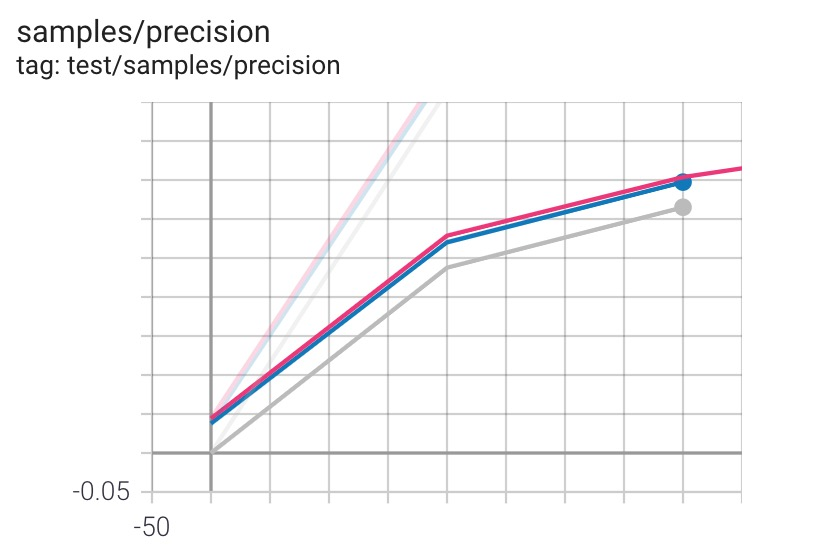

Tests ran for values 0.2(pink), 0.4(blue), 0.6(grey). 0.2 was the optimal vale for the model. 

#Shuffle

I experimented with setting shuffle to True/False.

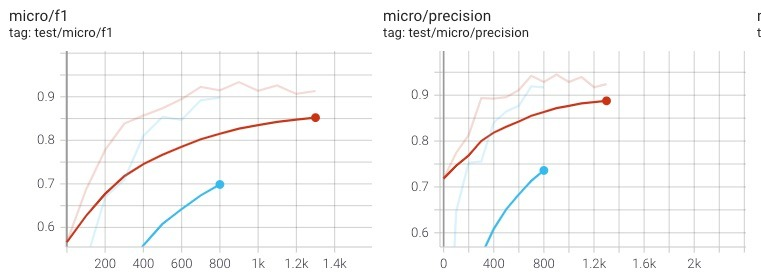

The Micro/f1 score here was much better for True (83%) after 10 epochs   compared to the False parameter (70%) after 10 epochs ~800 iterations

#Data Augmentation

Proceeding with the skeletal images I ran the data augmentation on the images file to increase the volume of training data for the model. The goal of this was to decrese chances of overfitting. 
The results were excellent and I was able to achieve training and validation scores of higher than 96%. 



In [ ]:
# Run training
class ModelTrainer():
  def __init__(self, train_dataset, test_dataset, path, image_v, label_csv_path, img_folder):
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset
    self.path = path
    self.img_folder = img_folder
    self.image_v = image_v
    self.label_csv_path = label_csv_path

    # Initialize the training parameters.
    self.num_workers = 8 # Number of CPU processes for data preprocessing
    #hyper-parameter tuning
    self.parameters = dict(
        lr = [1e-4], # Learning rate
        batch_size = [64],
        shuffle = [True],
        dropout = [0.5]
    )
    self.param_values = [v for v in self.parameters.values()]
    self.save_freq = 1 # Save checkpoint frequency (epochs)
    self.test_freq = 100 # Test model frequency (iterations)
    self.max_epoch_number = 10 # Number of epochs for training 
    # Note: on the small subset of data overfitting happens after 30-35 epochs
    self.device = torch.device('cuda')
    # Save path for checkpoints
    self.save_path = self.path + 'chekpoints'
    # Save path for logs
    self.logdir = self.path + 'logs/'

  #Initialize the dataloaders for training.
  def __initialise_model(self):
    # Initialize the model
    model = Resnext50(len(self.train_dataset.classes))
    # Switch model to the training mode and move it to GPU.
    model.train()
    self.model = model

  def view_tensorboard(self):
    # Run tensorboard
    %load_ext tensorboard
    %tensorboard --logdir {self.logdir}


  # Here is an auxiliary function for checkpoint saving.
  def __checkpoint_save(self, model, save_path, epoch):
    f = os.path.join(save_path, 'checkpoint-{:06d}.pth'.format(epoch))
    if 'module' in dir(model):
        torch.save(model.module.state_dict(), f)
    else:
        torch.save(model.state_dict(), f)
    print('saved checkpoint:', f)
  

  # Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.
  def __calculate_metrics(self, pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }


  def train(self):

    self.__initialise_model()
    logged = os.listdir(self.logdir)
    logged = [i for i in logged]
    for run_id, (lr,batch_size, shuffle, dropout) in enumerate(product(*self.param_values)):
        name = "{}-{}-{}-batch_size-{}-lr-{}-shuffle-{}-dropout".format(self.image_v, self.label_csv_path, batch_size, 
                                                              lr, shuffle, dropout)
        run = run_id + 1
        print("run id: " + str(run) + ' ' + name)
        if name in logged: 
          continue                               
        train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, num_workers=self.num_workers, shuffle=shuffle,
                                      drop_last=True)
        test_dataloader = DataLoader(self.test_dataset, batch_size=batch_size, num_workers=self.num_workers)

        num_train_batches = int(np.ceil(len(self.train_dataset) / batch_size))

        self.model = self.model.to(self.device)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        # If more than one GPU is available we can use both to speed up the training.
        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)

        os.makedirs(os.path.join(self.save_path, name), exist_ok=True)
        # Loss function
        criterion = nn.BCELoss()
        # Tensoboard logger
        logger = SummaryWriter(self.logdir + name)

        epoch = 0
        iteration = 0
        while True:
            batch_losses = []
            batch_acc = []
            total_loss = 0
            total_correct = 0
            for imgs, targets in train_dataloader:
              print(imgs)
            for imgs, targets in train_dataloader:
                imgs, targets = imgs.to(device), targets.to(device)

                optimizer.zero_grad()

                model_result = self.model(imgs)
                loss = criterion(model_result, targets.type(torch.float))
                total_loss+= loss.item()
                
                batch_loss_value = loss.item()
                loss.backward()
                optimizer.step()

                logger.add_scalar('train_loss', batch_loss_value, iteration)
                batch_losses.append(batch_loss_value)
                with torch.no_grad():
                    result = self.__calculate_metrics(model_result.cpu().numpy(), targets.cpu().numpy())
                    for metric in result:
                        logger.add_scalar('train/' + metric, result[metric], iteration)
                    batch_acc.append(result['micro/f1'])
                if iteration % test_freq == 0:
                    self.model.eval()
                    with torch.no_grad():
                        model_result = []
                        targets = []
                        for imgs, batch_targets in test_dataloader:
                            imgs = imgs.to(device)
                            model_batch_result = self.model(imgs)
                            model_result.extend(model_batch_result.cpu().numpy())
                            targets.extend(batch_targets.cpu().numpy())

                    result = __self.calculate_metrics(np.array(model_result), np.array(targets))
                    for metric in result:
                        logger.add_scalar('test/' + metric, result[metric], iteration)
                    print("epoch:{:2d} iter:{:3d} test: "
                          "micro f1: {:.3f} "
                          "precision: {:.3f} "
                          "samples f1: {:.3f}".format(epoch, iteration,
                                                      result['micro/f1'],
                                                      result['micro/precision'],
                                                      result['samples/f1']))

                    self.model.train()
                iteration += 1
            loss_value = np.mean(batch_losses)
            train_acc = np.mean(batch_acc)
            print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
            print("epoch:{:2d} iter:{:3d} train: loss:{:.3f} train: acc:{:.3f}".format(epoch, iteration, loss_value,train_acc))
            if epoch % self.save_freq == 0:
                self.__checkpoint_save(self.model, os.path.join(self.save_path, name), epoch)
            epoch += 1
            if self.max_epoch_number < epoch:
                break
            print("__________________________________________________________")

        logger.add_hparams(
                {"lr": lr, "bsize": batch_size, "shuffle":shuffle},
                {
                    "accuracy": total_correct/ len(self.train_dataset),
                    "loss": total_loss,
                },
            )

        logger.close()
  

  # Run inference on the test data for visualisation of model
  def inference(self):
    self.model.eval()
    self.model = self.model.to(self.device)
    for sample_id in range(0, len(self.test_dataset)):
        test_img, test_labels = self.test_dataset[sample_id]
        test_img_path = os.path.join(self.img_folder, self.test_dataset.imgs[sample_id])
        with torch.no_grad():
            inp = test_img.unsqueeze(0).cuda()
            raw_pred = self.model(inp).cpu().numpy()[0]
            raw_scores = []
            for pred in raw_pred:
              if pred > 0.5:
                  raw_scores.append(pred)
            raw_pred = np.array(raw_pred > 0.5, dtype=float)

        predicted_labels = np.array(self.test_dataset.classes)[np.argwhere(raw_pred > 0)[:, 0]]
        if not len(predicted_labels):
          output = ['no predictions']
        else:
          output = []
          for i in range(0, len(predicted_labels)):
            output.append(predicted_labels[i] + ': ' + str(round(raw_scores[i], 2)))
        img_labels = np.array(self.test_dataset.classes)[np.argwhere(test_labels > 0)[:, 0]]
        plt.imshow(Image.open(test_img_path))
        plt.title("Predicted labels: {} \nGT labels: {}".format(output, ', '.join(img_labels)))
        plt.axis('off')
        plt.show()


In [ ]:

# Simple dataloader and label binarization, that is converting test labels into binary arrays of length 27 (number of classes) with 1 in places of applicable labels).
class ImagesDataset(Dataset):
    def __init__(self, data_path, anno_path, transforms):
        self.transforms = transforms
        with open(anno_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']

        self.imgs = []
        self.annos = []
        self.data_path = data_path
        print('loading', anno_path)
        for sample in samples:
            self.imgs.append(sample['image_name'])
            self.annos.append(sample['image_labels'])
        for item_id in range(len(self.annos)):
            item = self.annos[item_id]
            vector = [cls in item for cls in self.classes]
            self.annos[item_id] = np.array(vector, dtype=float)

    def __getitem__(self, item):
        anno = self.annos[item]
        img_path = os.path.join(self.data_path, self.imgs[item])
        img = Image.open(img_path)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, anno

    def __len__(self):
        return len(self.imgs)

In [ ]:
# Calculate label distribution for the entire dataset (train + test)
def show_label_distribution(dataset_train, dataset_val):
  samples = dataset_val.annos + dataset_train.annos
  samples = np.array(samples)
  with printoptions(precision=3, suppress=True):
      class_counts = np.sum(samples, axis=0)
      # Sort labels according to their frequency in the dataset.
      sorted_ids = np.array([i[0] for i in sorted(enumerate(class_counts), key=lambda x: x[1])], dtype=int)
      plt.barh(range(len(dataset_val.classes)), width=class_counts[sorted_ids])
      plt.yticks(range(len(dataset_val.classes)), np.array(dataset_val.classes)[sorted_ids])
      plt.gca().margins(y=0)
      plt.grid()
      plt.title('Label distribution')
      plt.show()

In [ ]:
# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [ ]:
# Test preprocessing
class Transforms():
  def __init__(self):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    self.val_transform = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])
    self.train_transform = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(),
      transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
                              shear=None, resample=False, 
                              fillcolor=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])

In [ ]:
class InitialiseModels():
  def __init__(self, path):
    plain_image_model = os.path.join(path, 'chekpoints/human_tiles_multiply-human_tiles_multiply.csv-64-batch_size-0.0001-lr-True-shuffle-0.2-dropout/checkpoint-000010.pth')
    skeleton_image_model = os.path.join(path, 'chekpoints/skeletal_only_multiply-skeletal_only_multiply.csv-64-batch_size-0.0001-lr-True-shuffle-0.2-dropout/checkpoint-000017.pth')
    self.plain_model = Resnext50(18)
    self.plain_model.load_state_dict(torch.load(plain_image_model))
    self.plain_model.eval()
    self.skel_model = Resnext50(18)
    self.skel_model.load_state_dict(torch.load(skeleton_image_model))
    self.skel_model.eval()
    self.pose_detect_model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True,
                                                               num_keypoints=17)
    self.pose_detect_model.eval()
    if torch.cuda.is_available():
      self.pose_detect_model.cuda()
      self.skel_model.cuda()
      self.plain_model.cuda()

In [ ]:
def run(img_path, path):
  initialised_models = InitialiseModels(path)

  out_csv = os.path.join(path, 'results.csv') 
  input_img = os.listdir(img_path)
  input_img = [i for i in input_img]
  #input_img.shuffle()
  with open(out_csv,'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image", "Preidicted Actions"])
  file.close()
  for i in range(0, len(input_img[:100])):

    if not input_img[i].endswith('.png'):
      continue
    classifier = PoseClassifier(os.path.join(img_path, input_img[i]), initialised_models.skel_model, initialised_models.plain_model, initialised_models.pose_detect_model)
    result = classifier.run()
    plt.imshow(Image.open(os.path.join(img_path, input_img[i])))
    plt.title("Predicted labels: {}".format(result))
    plt.axis('off')
    plt.show()
    with open(out_csv,'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([input_img[i], str(result)])
    file.close()
  


In [ ]:

# Use this funciton if you want to retrain the model

def trainModel():
  path = '/content/drive/MyDrive/HawkEye/'
  initialised_models = InitialiseModels(path)
  source_images = 'human_tiles_multiply'
  img_folder = os.path.join(path, source_images)
  label_csv_path = 'human_tiles_multiply.csv' 

  
  ## IMAGE PROCESSING

  #image_pre_processor = ImageSetPreProcessor(img_folder, img_folder + '_labelled', initialised_models.pose_detect_model,)
  #image_pre_processor.create_labels()
  #image_pre_processor.apply_skeleton(img_folder + '_labelled')
  #image_pre_processor.dataset_multiply(img_folder + '_labelled', img_folder + '_labelled' + '.csv')


  ## TRAINING 

  #  Note: if you have just created the lables and datasets in the Image Processing section, you will probably 
  # need to chang the source_images and label_csv_path, as those processes create new image folders and csv files 

  test_train_data = TestTrainData(label_csv_path, path, img_folder)
  test_train_data.create_test_train_datasets()
  model_trainer = ModelTrainer(test_train_data.dataset_train, test_train_data.dataset_val, path, source_images, label_csv_path, img_folder)
  model_trainer.train()
 
  # uncomment this if you want to see the output from the trained model 
  #model_trainer.inference()



## Final results

I produced two models for my final submission. The skeletal-only model had a final f1 micro score of 91%
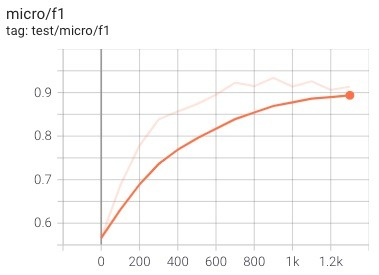

My model for images which I wasn't able to detect a skeleton had a f1 micro score  76%:

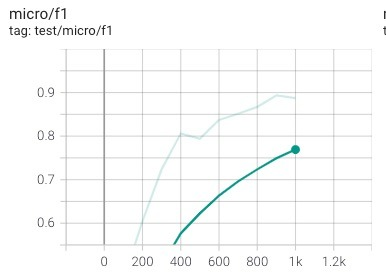


In [ ]:
  # This main function will classify all models in the given image path and save the output to a csv file
  def main(img_path, path):
    run(os.path.join(path, img_path), path)

In [ ]:
main('human_tiles','/content/drive/MyDrive/HawkEye/' ))

# Areas for improvement

I only managed to get through lablelling 1000 or so of the images, so performance could be improved with more labelling

It would have been interesting to try some more image processing - maybe removing all parts of the image apart from the subject. 